In [2]:
import pandas as pd  # for import file(csv,excel,etc)

import numpy as np # for numerical opt.
import seaborn as sns # adv. visulazation
import matplotlib.pyplot as plt  # basic visulaztion
import warnings
warnings.filterwarnings('ignore')

In [5]:
data=pd.read_csv("C:/Users/LJIN/Downloads/AMZN.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-29,52.820000,53.480000,51.430000,51.900002,51.900002,11947100
1,2004-01-05,52.000000,53.599998,49.099998,51.590000,51.590000,49611800
2,2004-01-12,51.610001,56.779999,50.799999,55.720001,55.720001,56438800
3,2004-01-19,55.570000,57.820000,55.410000,57.110001,57.110001,31243200
4,2004-01-26,56.799999,57.740002,48.599998,50.400002,50.400002,74001000


In [6]:
# Moving averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# RSI calculation
delta = data['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

data.dropna(inplace=True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI
779,2018-12-03,1769.459961,1778.339966,1609.849976,1629.130005,1629.130005,31922300,1802.264014,1637.130405,32.741213
780,2018-12-10,1623.839966,1704.989990,1585.000000,1591.910034,1591.910034,31976000,1790.996014,1645.579207,33.446097
781,2018-12-17,1566.000000,1584.530029,1363.959961,1377.449951,1377.449951,47777100,1768.704010,1648.545405,26.921459
782,2018-12-24,1346.000000,1513.469971,1307.000000,1478.020020,1478.020020,36182800,1748.290009,1652.001807,33.566493
783,2018-12-31,1510.800049,1520.760010,1487.000000,1501.969971,1501.969971,6954500,1729.277509,1656.149607,30.204736


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Use selected features
features = data[['Close', 'MA20', 'MA50', 'RSI']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Close price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 7.4247e-04 - val_loss: 0.0011
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.2226e-04 - val_loss: 0.0026
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.8318e-04 - val_loss: 0.0017
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 2.2402e-04 - val_loss: 0.0020
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 2.4594e-04 - val_loss: 0.0025
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2.9930e-04 - val_loss: 0.0024
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.1466e-04 - val_loss: 0.0017
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 2.3325e-04 - val_loss: 0.0019
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1.9421e-04 - val_loss: 0.0025
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.9399e-04 - val_loss: 0.0015
Epoch 12/20
16/16 ━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


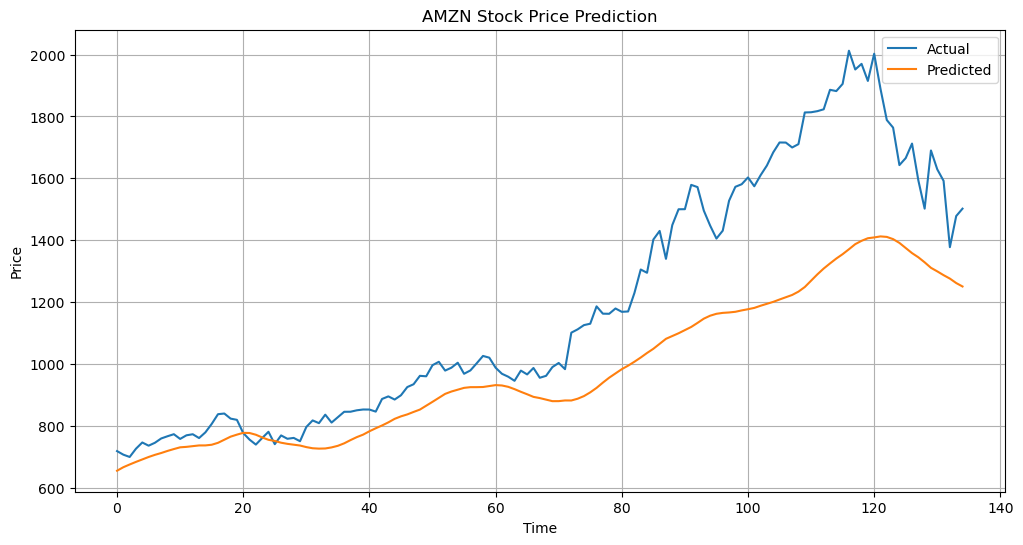

In [9]:
import matplotlib.pyplot as plt

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.concatenate((predicted, X_test[:, -1, 1:]), axis=1))[:, 0]
actual_prices = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual")
plt.plot(predicted_prices, label="Predicted")
plt.title("AMZN Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


DeltaGenerator()

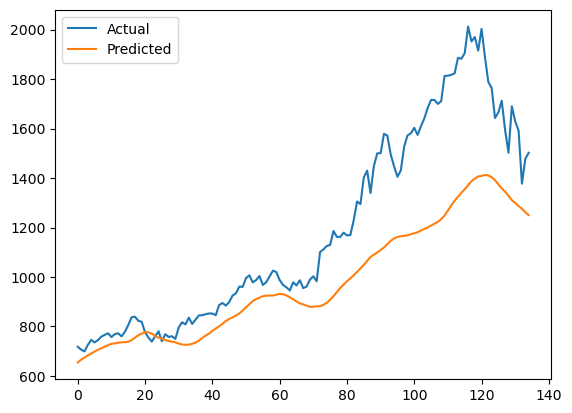

In [11]:
import streamlit as st
import matplotlib.pyplot as plt
import pandas as pd

st.title("Amazon Stock Price Prediction")
st.subheader("Predicted vs Actual Prices")

# Load data
df = pd.read_csv("C:/Users/LJIN/Downloads/AMZN.csv", parse_dates=['Date'])
st.line_chart(df[['Close']].tail(200))

# Show LSTM plot
fig, ax = plt.subplots()
ax.plot(actual_prices, label='Actual')
ax.plot(predicted_prices, label='Predicted')
ax.legend()
st.pyplot(fig)
